# **Assignment 01 - Programming Task**

# A* Search — Class based Implementation & Heuristic Experiments

### Objectives
- Implement A* as a class that works on a grid maze.
- Provide heuristics as functions (Manhattan, Scaled ×1.5, Admissible but Inconsistent).
- Check admissibility & consistency for each heuristic.
- For each (maze, heuristic) report:
  - Heuristic name,
  - Admissible? / Consistent?,
  - Path found,
  - Path cost,
  - Is path optimal?,

## Importants Imports

In [12]:
# Imports & plotting style
import heapq
from collections import deque
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Modern / clean matplotlib defaults
plt.rcParams.update({
    "figure.figsize": (6,6),
    "axes.facecolor": "#fafafa",
    "axes.edgecolor": "#e6e6e6",
    "axes.grid": True,
    "grid.color": "#efefef",
    "grid.linestyle": "-",
    "grid.linewidth": 0.7,
    "xtick.bottom": False,
    "ytick.left": False,
    "font.size": 10
})

# Colors used for heuristics (distinct, modern)
DEFAULT_COLORS = {
    "Manhattan": "#2E86AB",     # soft blue
    "Scaled x1.5": "#F6A01A",   # warm orange
    "Inconsistent": "#3FBF7F"   # soft green
}

print("Imports and style configured.")


Imports and style configured.


## GridMaze class

In [13]:
class GridMaze:
    def __init__(self, grid, start, goal):
        self.grid = np.array(grid)
        self.start = tuple(start)
        self.goal = tuple(goal)
        assert self.grid.ndim == 2, "Grid must be 2D"

    def neighbors(self, pos):
        r, c = pos
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < self.grid.shape[0] and 0 <= nc < self.grid.shape[1] and self.grid[nr, nc] == 0:
                yield (nr, nc)

    def pretty_print(self):
        """ASCII print of grid (A = start, B = goal, # = wall, . = free)"""
        rows, cols = self.grid.shape
        for r in range(rows):
            line = ""
            for c in range(cols):
                if (r,c) == self.start:
                    line += "A "
                elif (r,c) == self.goal:
                    line += "B "
                elif self.grid[r,c] == 1:
                    line += "# "
                else:
                    line += ". "
            print(line.rstrip())
        print()

    def overlay_path_ascii(self, path):
        """Return ASCII string with path marked by '*'"""
        rows, cols = self.grid.shape
        chars = [['#' if self.grid[r,c]==1 else '.' for c in range(cols)] for r in range(rows)]
        if path:
            for (r,c) in path:
                chars[r][c] = '*'
        sr, sc = self.start; gr, gc = self.goal
        chars[sr][sc] = 'A'; chars[gr][gc] = 'B'
        return "\n".join(" ".join(row) for row in chars)

    def bfs_distances(self):
        """Compute true shortest distance from every reachable node to goal (BFS from goal)."""
        goal = self.goal
        dist = {}
        q = deque([goal])
        dist[goal] = 0
        while q:
            cur = q.popleft()
            for nb in self.neighbors(cur):
                if nb not in dist:
                    dist[nb] = dist[cur] + 1
                    q.append(nb)
        return dist

    def shortest_path(self):
        """Return (path, cost) from start to goal using BFS (unit cost). If unreachable, (None, inf)."""
        start, goal = self.start, self.goal
        if start == goal:
            return [start], 0
        parent = {start: None}
        q = deque([start])
        while q:
            cur = q.popleft()
            if cur == goal:
                break
            for nb in self.neighbors(cur):
                if nb not in parent:
                    parent[nb] = cur
                    q.append(nb)
        if goal not in parent:
            return None, math.inf
        # reconstruct
        path = []
        cur = goal
        while cur is not None:
            path.append(cur)
            cur = parent[cur]
        path.reverse()
        return path, len(path)-1


## Heuristics helper class

In [14]:
class Heuristics:
    """Static helpers to create heuristic functions and check admissibility/consistency."""
    @staticmethod
    def manhattan(a, b):
        return abs(a[0]-b[0]) + abs(a[1]-b[1])

    @staticmethod
    def scaled_manhattan(scale):
        return lambda a, b: float(scale) * Heuristics.manhattan(a, b)

    @staticmethod
    def build_inconsistent(maze: GridMaze):
        true_dist = maze.bfs_distances()
        if not true_dist:
            raise ValueError("Goal not reachable; cannot build heuristic.")
        hvals = dict(true_dist)  
        for n in list(hvals.keys()):
            for n2 in maze.neighbors(n):
                if n2 in hvals and hvals[n] == hvals[n2] + 1 and hvals[n2] >= 2:
                    hvals[n2] = hvals[n2] - 2  # still ≤ true dist, so admissible
                    return lambda a, b, table=hvals: table.get(a, float('inf'))
        # fallback: reduce by 1
        for n in list(hvals.keys()):
            for n2 in maze.neighbors(n):
                if n2 in hvals and hvals[n] == hvals[n2] + 1 and hvals[n2] >= 1:
                    hvals[n2] = hvals[n2] - 1
                    return lambda a, b, table=hvals: table.get(a, float('inf'))
        # if not possible, return Manhattan
        return lambda a, b: Heuristics.manhattan(a, b)

    @staticmethod
    def check_admissible(maze: GridMaze, h):
        """Return (True/False, examples) where examples are nodes violating admissibility."""
        true_dist = maze.bfs_distances()
        violations = []
        for node, td in true_dist.items():
            hv = h(node, maze.goal)
            if hv > td + 1e-9:
                violations.append((node, hv, td))
        return len(violations) == 0, violations

    @staticmethod
    def check_consistent(maze: GridMaze, h):
        """Return (True/False, examples) where examples are edges violating consistency."""
        true_dist = maze.bfs_distances()
        violations = []
        for n in true_dist.keys():
            for n2 in maze.neighbors(n):
                if n2 not in true_dist:
                    continue
                if h(n, maze.goal) > 1 + h(n2, maze.goal) + 1e-9:
                    violations.append((n, n2, h(n, maze.goal), h(n2, maze.goal)))
        return len(violations) == 0, violations


## AStarSolver class

In [15]:
class AStarSolver:
    def __init__(self, maze: GridMaze, heuristic):
        self.maze = maze
        self.h = heuristic

    def search(self):
        start, goal = self.maze.start, self.maze.goal
        if start == goal:
            return [start], 0, 0, {}

        open_heap = []
        gscore = {start: 0}
        # heap entries: (f, g, node)
        heapq.heappush(open_heap, (self.h(start, goal), 0, start))
        came_from = {}
        expanded = set()
        nodes_expanded = 0

        while open_heap:
            f, g, current = heapq.heappop(open_heap)
            # skip stale entries
            if g > gscore.get(current, math.inf):
                continue
            # expand
            nodes_expanded += 1
            expanded.add(current)
            if current == goal:
                break
            for nb in self.maze.neighbors(current):
                tentative_g = g + 1
                if tentative_g < gscore.get(nb, math.inf):
                    gscore[nb] = tentative_g
                    came_from[nb] = current
                    heapq.heappush(open_heap, (tentative_g + self.h(nb, goal), tentative_g, nb))

        if goal not in gscore:
            return None, math.inf, nodes_expanded, gscore

        # reconstruct path
        path = []
        cur = goal
        while cur is not None:
            path.append(cur)
            cur = came_from.get(cur, None)
        path.reverse()
        return path, gscore[goal], nodes_expanded, gscore


## Visualizer class - combined path plot and comparison bar chart

In [16]:
from matplotlib.lines import Line2D

class Visualizer:
    def __init__(self, figsize=(7,7), cmap="cividis"):
        self.cmap = cmap
        self.figsize = figsize

    def plot_combined_paths(self, maze: GridMaze, results: list, title="Paths comparison"):
        """
        results: list of dicts {'label':str,'path':list of coords,'color':hex}
        Draws the grid background and overlays each path.
        """
        plt.figure(figsize=self.figsize)
        # grid background (walls=1, free=0). Show with cividis for a modern look.
        plt.imshow(maze.grid, cmap=self.cmap, interpolation="nearest")
        ax = plt.gca()
        ax.set_xticks([]); ax.set_yticks([])
        # annotate start and goal
        sr, sc = maze.start; gr, gc = maze.goal
        plt.text(sc, sr, "A", ha="center", va="center", fontsize=12, color="white", fontweight="bold")
        plt.text(gc, gr, "B", ha="center", va="center", fontsize=12, color="red", fontweight="bold")
        # overlay each path with smooth line style
        legend_handles = []
        for r in results:
            path = r.get("path")
            label = r.get("label")
            color = r.get("color", "#000000")
            if not path:
                continue
            xs = [p[1] for p in path]
            ys = [p[0] for p in path]
            # use alpha and linewidth for smooth modern effect
            plt.plot(xs, ys, linewidth=3, alpha=0.95, color=color, solid_capstyle='round')
            plt.scatter(xs, ys, s=40, edgecolor='white', linewidth=0.6, color=color, zorder=5)
            legend_handles.append(Line2D([0],[0], color=color, lw=3, label=label))
        if legend_handles:
            plt.legend(handles=legend_handles, loc='upper left', frameon=True)
        plt.title(title)
        plt.show()

    def plot_expansion_comparison(self, stats: dict, title="Nodes expanded comparison"):
        """
        stats: dict label -> nodes_expanded
        """
        labels = list(stats.keys())
        values = [stats[k] for k in labels]
        colors = [DEFAULT_COLORS.get(l, "#666666") for l in labels]
        plt.figure(figsize=(6,3.5))
        bars = plt.bar(labels, values, color=colors, alpha=0.95)
        plt.ylabel("Nodes expanded")
        plt.title(title)
        # add value labels
        for bar in bars:
            h = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)), ha='center', va='bottom', fontsize=9)
        plt.ylim(0, max(values)*1.25 if values else 1)
        plt.show()


## Define an example maze and instantiate classes

In [17]:
# Define the maze (0 free, 1 wall)
grid = [
    [0,0,0,0,0,0,0],
    [0,1,1,0,1,1,0],
    [0,1,0,0,0,1,0],
    [0,1,0,1,0,1,0],
    [0,0,0,1,0,0,0],
    [0,1,0,0,0,1,0],
    [0,0,0,1,0,0,0]
]
start = (0,0)
goal = (6,6)

maze = GridMaze(grid, start, goal)
print("Maze (ASCII):")
maze.pretty_print()

Maze (ASCII):
A . . . . . .
. # # . # # .
. # . . . # .
. # . # . # .
. . . # . . .
. # . . . # .
. . . # . . B



## Prepare heuristics and run experiments

In [18]:
# Prepare heuristics
h_man = lambda a,b: Heuristics.manhattan(a,b)
h_scaled = Heuristics.scaled_manhattan(1.5)
h_incons = Heuristics.build_inconsistent(maze)

heuristics = [
    ("Manhattan", h_man),
    ("Scaled x1.5", h_scaled),
    ("Inconsistent", h_incons)
]

# Run experiments
results = []
for name, h in heuristics:
    solver = AStarSolver(maze, h)
    path, cost, nodes_expanded, gscore = solver.search()
    true_path, true_cost = maze.shortest_path()
    adm, adm_viol = Heuristics.check_admissible(maze, h)
    cons, cons_viol = Heuristics.check_consistent(maze, h)
    is_opt = (cost == true_cost)
    ascii_map = maze.overlay_path_ascii(path)
    comment = ""
    if not adm:
        comment = "Not admissible (overestimates) → may return non-optimal path."
    elif not cons:
        comment = "Admissible but not consistent → may re-open nodes / expand more."
    else:
        comment = "Admissible & consistent → guaranteed optimal and no re-openings."
    results.append({
        "heuristic": name,
        "path": path,
        "path_cost": cost,
        "true_cost": true_cost,
        "nodes_expanded": nodes_expanded,
        "admissible": adm,
        "admissibility_violations": adm_viol[:3],
        "consistent": cons,
        "consistency_violations": cons_viol[:3],
        "ascii": ascii_map,
        "is_optimal": is_opt,
        "comment": comment
    })

# Show concise summary table
df_summary = pd.DataFrame([{
    "heuristic": r["heuristic"],
    "admissible": r["admissible"],
    "consistent": r["consistent"],
    "path_cost": r["path_cost"],
    "true_cost": r["true_cost"],
    "is_optimal": r["is_optimal"],
    "nodes_expanded": r["nodes_expanded"]
} for r in results])

df_summary


,heuristic,admissible,consistent,path_cost,true_cost,is_optimal,nodes_expanded
0,Manhattan,True,True,12,12,True,34
1,Scaled x1.5,False,False,12,12,True,13
2,Inconsistent,True,False,12,12,True,30


## Print detailed outputs per heuristic

In [19]:
for r in results:
    print("="*60)
    print("Heuristic:", r["heuristic"])
    print("Admissible?:", r["admissible"])
    if not r["admissible"] and r["admissibility_violations"]:
        print("  Example admissibility violation (node, h(node), true_dist):", r["admissibility_violations"])
    print("Consistent?:", r["consistent"])
    if not r["consistent"] and r["consistency_violations"]:
        print("  Example consistency violation (n, n2, h(n), h(n2)):", r["consistency_violations"])
    print("Path found (coords):", r["path"])
    print("Path cost:", r["path_cost"])
    print("True shortest cost (BFS):", r["true_cost"])
    print("Is path optimal?:", "Yes" if r["is_optimal"] else "No")
    print("Nodes expanded:", r["nodes_expanded"])
    print("Short comment:", r["comment"])
    print("\nASCII with path (A=start, B=goal, *=path):")
    print(r["ascii"])
    print()


Heuristic: Manhattan
Admissible?: True
Consistent?: True
Path found (coords): [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6)]
Path cost: 12
True shortest cost (BFS): 12
Is path optimal?: Yes
Nodes expanded: 34
Short comment: Admissible & consistent → guaranteed optimal and no re-openings.

ASCII with path (A=start, B=goal, *=path):
A * * * * * *
. # # . # # *
. # . . . # *
. # . # . # *
. . . # . . *
. # . . . # *
. . . # . . B

Heuristic: Scaled x1.5
Admissible?: False
  Example admissibility violation (node, h(node), true_dist): [((5, 6), 1.5, 1), ((6, 5), 1.5, 1), ((4, 6), 3.0, 2)]
Consistent?: False
  Example consistency violation (n, n2, h(n), h(n2)): [((5, 6), (6, 6), 1.5, 0.0), ((6, 5), (6, 6), 1.5, 0.0), ((4, 6), (5, 6), 3.0, 1.5)]
Path found (coords): [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6)]
Path cost: 12
True shortest cost (BFS): 12
Is path optimal?: Yes
No

# Visualizations:

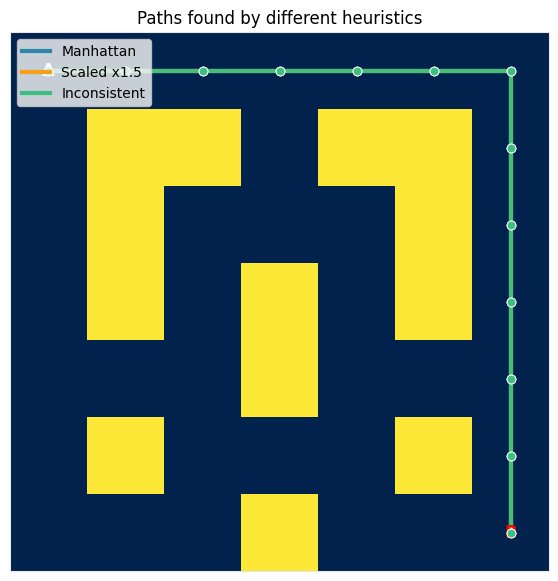

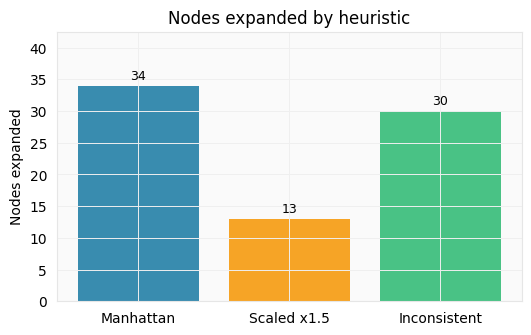

In [20]:
# Build input for visualizer
viz = Visualizer(figsize=(7,7), cmap="cividis")
plot_inputs = []
exp_stats = {}
for r in results:
    label = r["heuristic"]
    color = DEFAULT_COLORS.get(label, "#333333")
    plot_inputs.append({"label": label, "path": r["path"], "color": color})
    exp_stats[label] = r["nodes_expanded"]

# Combined paths overlay
viz.plot_combined_paths(maze, plot_inputs, title="Paths found by different heuristics")

# Nodes expanded comparison
viz.plot_expansion_comparison(exp_stats, title="Nodes expanded by heuristic")
